# Coronavirus (covid19) Tweets
## Tweets using hashtags associated with Coronavirus



This dataset contains the Tweets of users who have applied the following hashtags: 

**coronavirus, coronavirusoutbreak, coronavirusPandemic, covid19, covid_19, epitwitter, ihavecorona**


The goal of this analysis is to understand Twitter discourse around COVID-19

For that reason, we'll attemp to answer the following questions:

- Do more tweets about coronavirus indicate greater public awareness and seriousness and lead to a greater public acceptance of measures to limit spread, such as social distancing, and therefore fewer infections?

- Are some hashtags spreading more rapidly than others?

- Are tweeters prone to discussion (tweet replies) or sharing (quoted tweets)?

- Are people tweeting about particular symptoms?

and we'll do it with some basic Social Network Analysis (Part 1) and NLP (Part 2)


Source: https://www.kaggle.com/smid80/coronavirus-covid19-tweets

In [1]:
%rel3oad_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
! pip install kaggle --upgrade
! pip install node2vec
! pip install tqdm 
! pip install emoji

In [53]:
import warnings
warnings.filterwarnings('ignore')
import kaggle
from pathlib import Path
import os
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
from datetime import datetime, date
from collections import Counter
import re
from tqdm.auto import tqdm
import emoji
import string
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from node2vec import Node2Vec
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import seaborn as sns
#mpl.style.use('seaborn')
plt.style.use('ggplot')

## Download Covid-19-Tweets from Kaggle

In [ ]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [3]:
path = Path('data')
# path.mkdir(parents=True, exist_ok=True)

In [21]:
#!kaggle datasets download smid80/coronavirus-covid19-tweets

100%|█████████████████████████████████████▉| 2.27G/2.27G [08:54<00:00, 6.85MB/s]
100%|██████████████████████████████████████| 2.27G/2.27G [08:54<00:00, 4.55MB/s]


In [26]:
#! unzip -q -n coronavirus-covid19-tweets.zip -d $path

In [4]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/2020-03-30 Coronavirus Tweets.CSV
data/.DS_Store
data/Countries.CSV
data/2020-04-01 Coronavirus Tweets.CSV
data/Hashtags.CSV
data/2020-03-00 Coronavirus Tweets (pre 2020-03-12).CSV
data/2020-03-31 Coronavirus Tweets.CSV
data/2020-03-24 Coronavirus Tweets.CSV
data/2020-03-15 Coronavirus Tweets.CSV
data/2020-03-29 Coronavirus Tweets.CSV
data/2020-03-23 Coronavirus Tweets.CSV
data/2020-03-12 Coronavirus Tweets.CSV
data/2020-03-18 Coronavirus Tweets.CSV
data/2020-03-20 Coronavirus Tweets.CSV
data/2020-03-27 Coronavirus Tweets.CSV
data/2020-03-16 Coronavirus Tweets.CSV
data/2020-03-17 Coronavirus Tweets.CSV
data/2020-03-26 Coronavirus Tweets.CSV
data/2020-03-21 Coronavirus Tweets.CSV
data/2020-03-19 Coronavirus Tweets.CSV
data/2020-03-13 Coronavirus Tweets.CSV
data/2020-03-22 Coronavirus Tweets.CSV
data/2020-03-28 Coronavirus Tweets.CSV
data/2020-03-14 Coronavirus Tweets.CSV
data/2020-03-25 Coronavirus Tweets.CSV


In [6]:
list_files = []

for dirname, _, filenames in os.walk(path):
    for filename in tqdm(filenames):
        if 'Coronavirus Tweets' in filename:
            df = pd.read_csv(os.path.join(dirname, filename), index_col=None, header=0)
            list_files.append(df)

df = pd.concat(list_files, axis=0, ignore_index=True)

In [7]:
df.shape

(14722353, 22)

In [8]:
df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1244414033547030529,1054394794305302528,2020-03-30T00:00:00Z,Ecodiariozac,"#Entérate Gobierno del Estado, a través de sus...",TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,679,991,NaN,2018-10-22T15:31:23Z,False,es
1,1244414034411171845,31023547,2020-03-30T00:00:00Z,Reporte_Indigo,"#PorSiNoLoViste | Si eres un cliente cumplido,...",TweetDeck,NaN,NaN,NaN,False,...,8,NaN,NaN,NaN,898366,621,NaN,2009-04-14T01:47:10Z,True,es
2,1244414033333227523,296096105,2020-03-30T00:00:00Z,tv1_rtm,Pengurusan kes-kes POSITIF COVID-19\n\n#Perint...,TweetDeck,NaN,NaN,NaN,False,...,1,NaN,NaN,NaN,38609,534,NaN,2011-05-10T05:57:18Z,False,in
3,1244414034423590913,2963716598,2020-03-30T00:00:00Z,ajplusespanol,"Médico cirujano, doctor en epidemiología y sub...",Twitter Media Studio,NaN,NaN,NaN,False,...,24,NaN,NaN,NaN,114290,668,NaN,2015-01-07T18:44:40Z,True,es
4,1244414033672855552,4856038638,2020-03-30T00:00:00Z,BlogDelRegio,La @NlSalud implementará un protocolo de inves...,TweetDeck,NaN,NaN,NaN,False,...,1,NaN,NaN,NaN,6785,1523,NaN,2016-02-03T22:48:13Z,False,es


In [9]:
df.columns.tolist()

['status_id',
 'user_id',
 'created_at',
 'screen_name',
 'text',
 'source',
 'reply_to_status_id',
 'reply_to_user_id',
 'reply_to_screen_name',
 'is_quote',
 'is_retweet',
 'favourites_count',
 'retweet_count',
 'country_code',
 'place_full_name',
 'place_type',
 'followers_count',
 'friends_count',
 'account_lang',
 'account_created_at',
 'verified',
 'lang']

# Exploration

In [10]:
df['is_retweet'].unique()

array([False])

In [11]:
df['hour'] = pd.to_datetime(df['created_at']).map(lambda x: x.hour)
df['day'] = pd.to_datetime(df['created_at']).map(lambda x: x.date)
df['is_reply'] = ~df['reply_to_user_id'].isna()

In [12]:
replies_by_country = df.groupby('country_code').is_reply.value_counts().unstack()
quotes_by_country = df.groupby('country_code').is_quote.value_counts().unstack()
tweets_by_country = pd.merge(replies_by_country, quotes_by_country, 
                             on='country_code', suffixes=('_replies', '_quotes'))
tweets_by_country['total'] = tweets_by_country['False_quotes'] + tweets_by_country['True_quotes']
tweets_by_country = tweets_by_country.sort_values(by='total', ascending=False).dropna().reset_index()[:50]
tweets_by_country.head()

,country_code,False_replies,True_replies,False_quotes,True_quotes,total
0,US,205252.0,32070.0,195662.0,41660.0,237322.0
1,GB,58565.0,8700.0,56827.0,10438.0,67265.0
2,IN,45278.0,8424.0,47813.0,5889.0,53702.0
3,ES,30575.0,4563.0,30385.0,4753.0,35138.0
4,CA,25763.0,3904.0,23586.0,6081.0,29667.0


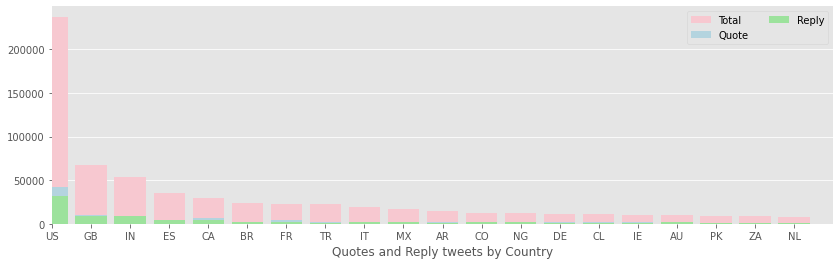

In [29]:
f, ax = plt.subplots(figsize=(14, 4))

sns.barplot(x="country_code", y="total", data=tweets_by_country[:20],
            label="Total", color="pink")

sns.barplot(x="country_code", y="True_quotes", data=tweets_by_country[:20],
            label="Quote", color="lightblue")

sns.barplot(x="country_code", y="True_replies", data=tweets_by_country[:20],
            label="Reply", color="lightgreen")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 20), ylabel="",
       xlabel="Quotes and Reply tweets by Country")
sns.despine(left=True, bottom=True)

In [14]:
tweets_by_country['true_replies_pct'] = tweets_by_country['True_replies']/tweets_by_country['total']
tweets_by_country['true_quotes_pct'] = tweets_by_country['True_quotes']/tweets_by_country['total']

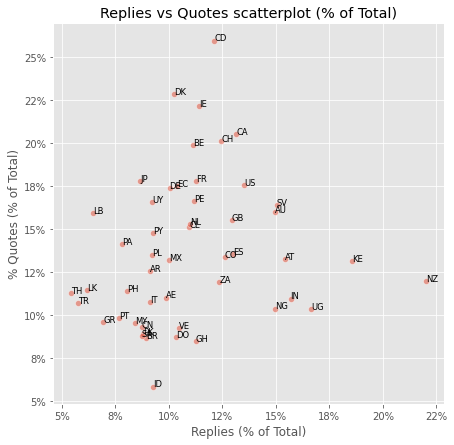

In [15]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x='true_replies_pct', y='true_quotes_pct', data=tweets_by_country, alpha = 0.5);
vals_x = ax.get_xticks()
vals_y = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
plt.title('Replies vs Quotes scatterplot (% of Total)')
plt.xlabel('Replies (% of Total)')
plt.ylabel('% Quotes (% of Total)')

for line in range(0,tweets_by_country.shape[0]):
     ax.text(tweets_by_country['true_replies_pct'][line], 
             tweets_by_country['true_quotes_pct'][line], 
             tweets_by_country['country_code'][line], 
             horizontalalignment='left', size='small', color='black');

In [16]:
country_dict = {'BR': 'Brazil', 'CA': 'Canada', 'ES': 'Spain', 'FR': 'France', 'GB': 'Great Britain',
               'IN': 'India', 'IT': 'Italy', 'MX': 'Mexico', 'TR': 'Turkey', 'US': 'United States'}

In [ ]:
top_countries = tweets_by_country['country_code'].unique()
countries_by_day = df[df['country_code'].isin(top_countries[:10])
                     ].groupby('day').country_code.value_counts().unstack(1)
countries_by_day = countries_by_day/countries_by_day.iloc[0]

Text(0.5, 1.0, 'Normalized amount of tweets by country (day 2020/03/01 = 1)')

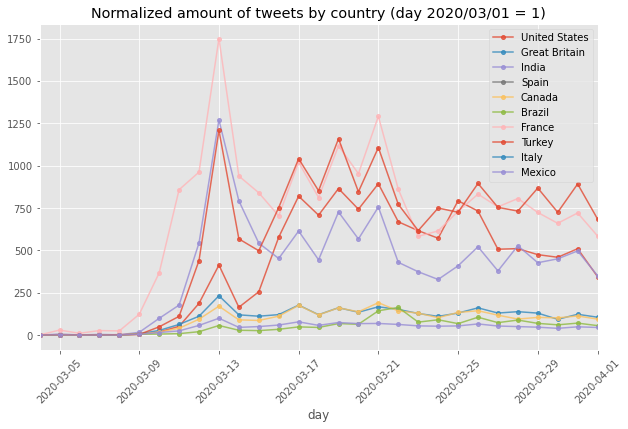

In [22]:
params={'markersize':8, 'alpha':0.8, 'style':'.-', 'rot':45}
ax = countries_by_day.plot(figsize=(10,6), **params)
ax.legend([country_dict[code] for code in top_countries[:10]])
ax.set_title('Normalized amount of tweets by country (day 2020/03/01 = 1)')

In [40]:
def extract(start, tweet):
    words = tweet.split()
    return [word[1:] for word in words if word[0] == start]

def strip_punctuation(s):
    return s.translate(str.maketrans('','','!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))

def extract_hashtags(tweet):
    hashtags = [strip_punctuation(tag) for tag in extract('#', tweet)]
    result = []
    for tag in hashtags:
        if tag.lower() not in result:  
            result.append(tag.lower())
    return result

def get_flat_list(plain_list):
    
    flat_list = []
    plain_list = [x for x in plain_list if len(x)>0]
    
    for sublist in tqdm(plain_list):
        for item in sublist:
            flat_list.append(item)
            
    flat_list = [x for x in flat_list if x!='']
    
    return flat_list

In [36]:
#(!pip install swifter) swifter makes pandas apply faster using parallelization 
#(https://towardsdatascience.com/add-this-single-word-to-make-your-pandas-apply-faster-90ee2fffe9e8)

import swifter

df['hashtags'] = df['text'].swifter.apply(extract_hashtags)
df[['text', 'hashtags']].head()

,text,hashtags
0,"#Entérate Gobierno del Estado, a través de sus...","[entérate, covid19, twitter, ecodiario, zacate..."
1,"#PorSiNoLoViste | Si eres un cliente cumplido,...","[porsinoloviste, covid19]"
2,Pengurusan kes-kes POSITIF COVID-19\n\n#Perint...,"[perintahkawalanpergerakan, dudukdirumah, stay..."
3,"Médico cirujano, doctor en epidemiología y sub...",[covid19]
4,La @NlSalud implementará un protocolo de inves...,"[nuevoleón, secretaríadesalud, plasma, pacient..."


In [41]:
list_hashtags = get_flat_list(df['hashtags'].tolist())

In [42]:
c = Counter(list_hashtags).most_common(30)
freq = [i[1] for i in c]
top_hashtags = [i[0] for i in c]

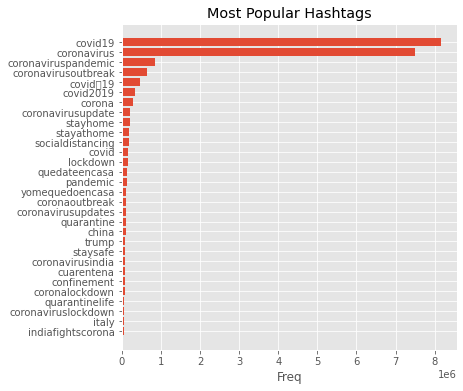

In [43]:
f, ax = plt.subplots(figsize=(6,6,))
plt.barh(top_hashtags, freq)
plt.title("Most Popular Hashtags")
plt.xlabel("Freq")
plt.gca().invert_yaxis()
plt.show()

In [44]:
def get_hashtag_network(df, hashtag: str):
    ''' returns a dataframe with the edges and timestamp from tweets feed (df)'''
    
    edges_df = df[(df.is_reply)  &
               (df.hashtags.map(lambda x: hashtag in x))][['user_id','reply_to_user_id', 'day']]
    
    edges_df = edges_df.dropna()
    edges_df = edges_df.drop_duplicates().reset_index(drop=True)
    edges_df = edges_df.rename(columns={'user_id': 'from', 'reply_to_user_id': 'to'})
    
    return edges_df


def get_strongly_gcc(G):
    """ get the giant strongly connected component of G""" 
    SGcc = max(nx.strongly_connected_components(G), key=len)
    SGcc = G.subgraph(SGcc)
    return SGcc

def get_weakly_gcc(G):
    """ get the giant weakly connected component of G"""  
    WGcc = max(nx.weakly_connected_components(G), key=len)
    WGcc = G.subgraph(WGcc)
    return WGcc

def get_edges_hashtags(country_code=None):
    ''' returns a dataframe with edges of hashtags that shared a common tweet'''
    if not country_code:
        list_Hashtags = df2['hashtags'].tolist()
    else:
        list_Hashtags = df2[df2.country_code==country]['hashtags'].tolist()
        
    edgelist = []

    for L in tqdm(list_Hashtags):
        for i in range(len(L)):
            for j in range(i+1,len(L)):
                edgelist.append([L[i], L[j]]) 

    edges_df = pd.concat([pd.DataFrame([i], columns=['from', 'to']) for i 
                          in tqdm(edgelist)], ignore_index=True)
    
    return edges_df   

def plot_network(G, G_degree=None):
    ''' plot the graph with varying nodesize '''
    
    plt.figure(num=None, figsize=(20, 20), dpi=60, facecolor='w', edgecolor='k')
    pos = nx.spring_layout(G)
    
    if G_degree:
        node_size=[v * 50 for v in dict(G_degree).values()]
    else:
        node_size = 1
        
    nx.draw(G, pos, nodelist=dict(G_degree).keys(), node_size=node_size, width=0.5, alpha=0.5, edge_color='b')
    plt.axis('off')
    plt.show()
    

# Social Network Analysis

### Example of a network: #quedateencasa

In [45]:
edges_df = get_hashtag_network(df, 'quedateencasa')

In [46]:
edges_df.head()

,from,to,day
0,105654627,1.085505e+18,2020-03-30
1,49794620,1.481541e+08,2020-03-30
2,142755969,1.198049e+08,2020-03-30
3,861601398055632900,2.507388e+07,2020-03-30
4,164923473,1.362353e+07,2020-03-30


In [47]:
G = nx.from_pandas_edgelist(edges_df, 'from', 'to', create_using=nx.DiGraph())

In [48]:
degrees = G.degree()

out_degrees = G.out_degree()
in_degrees = G.in_degree()

Text(0.5, 0, 'rank')

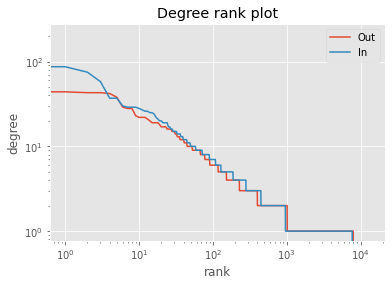

In [49]:
plt.loglog(sorted([n[1] for n in list(out_degrees)], reverse=True))
plt.loglog(sorted([n[1] for n in list(in_degrees)], reverse=True))
plt.title("Degree rank plot")
plt.legend(['Out', 'In'])
plt.ylabel("degree")
plt.xlabel("rank")

In [50]:
Gcc = get_weakly_gcc(G)
Gcc = Gcc.to_undirected()
Gcc_degree = Gcc.degree()

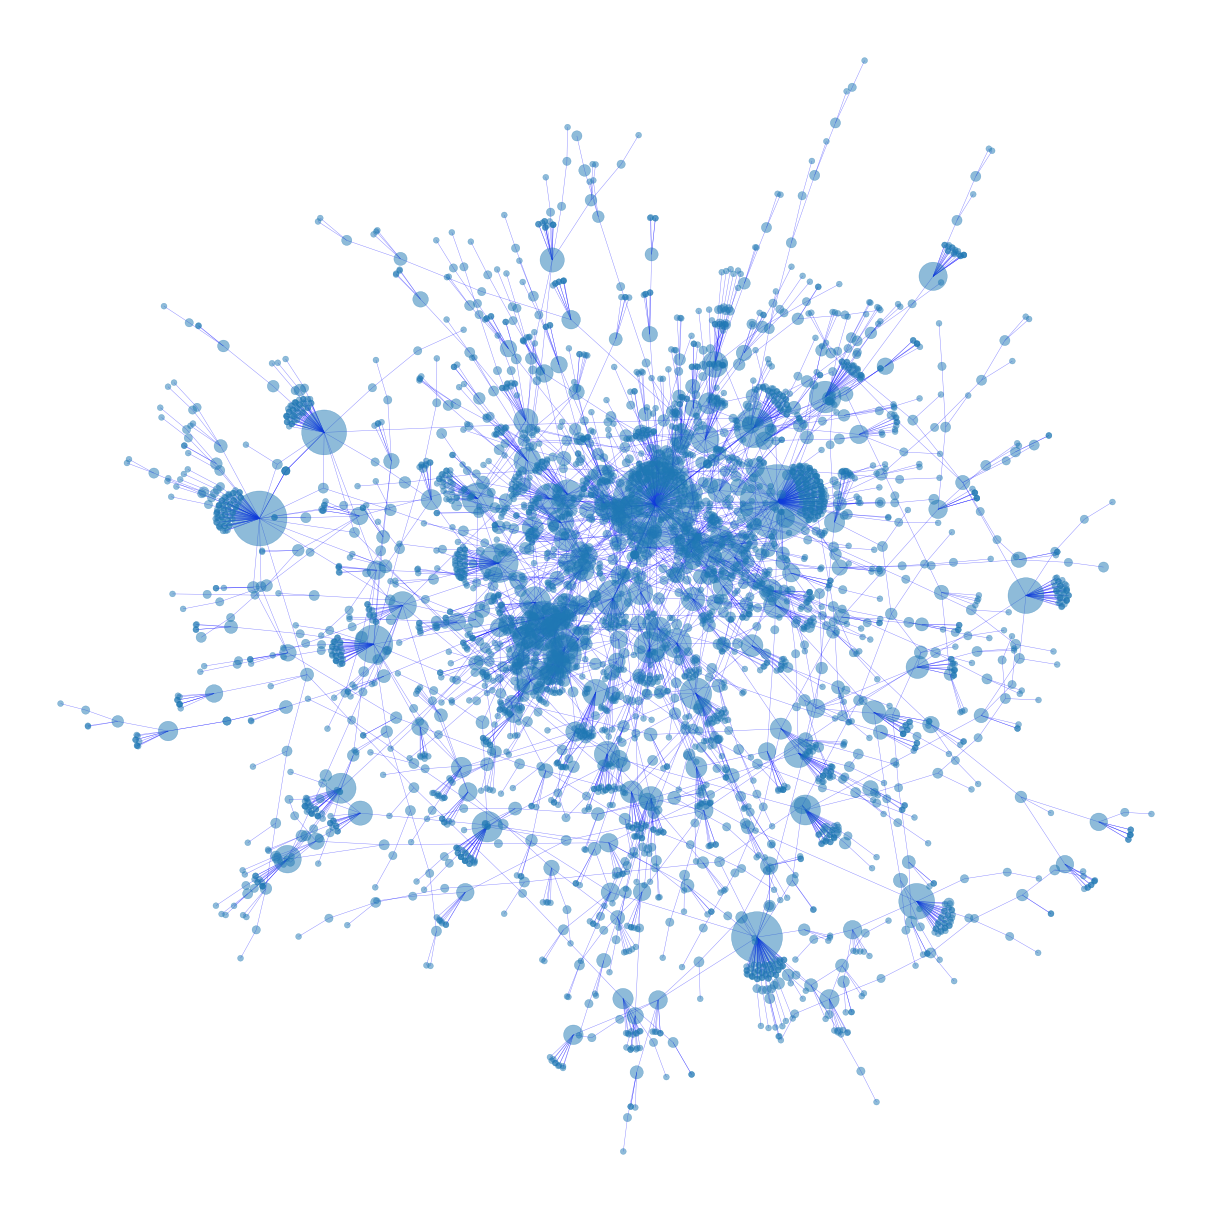

In [51]:
plot_network(Gcc, Gcc_degree)

### Measuring attributes evolution through time for multiple networks

In [ ]:
hashtag_list = ['stayhome', 'stayathome', 'cuarentena', 'lockdown', 'socialdistancing',
                'masks4all', 'quedateencasa', 'yomequedoencasa', 'flattenthecurve']

info = dict()
    
for hashtag in tqdm(hashtag_list):
    
    edges_df = get_hashtag_network(df, hashtag)
    days = edges_df.sort_values(by='day')['day'].unique().tolist()
    
    hashtag_info = {}
    
    # initiate an empty graph
    G_day = nx.DiGraph()
    
    for i in range(len(days)):
        
        day_info = {}
        edges = [tuple(x) for x in edges_df[edges_df.day == days[i]][['from', 'to']].drop_duplicates().to_numpy()]
        G_day.update(edges=edges) # updates graphs adding new edges
        G_day_cc = get_weakly_gcc(G_day) # get the giant connected component (for some measures)
        G_day_cc = G_day_cc.to_undirected()
        
        # graph properties
        n = G_day.number_of_nodes()
        e = G_day.number_of_edges()
        de = G_day.degree()
        avgde = np.mean([n[1] for n in list(de)])
        di = nx.diameter(G_day_cc)
        apl = nx.average_shortest_path_length(G_day_cc, weight=None)
        try:
            a = nx.degree_pearson_correlation_coefficient(G_day_cc)
        except:
            a = None
        
        # populates the graph info dict
        day_info['nodes'] = n
        day_info['edges'] = e
        day_info['degrees'] = de
        day_info['avg degrees'] = avgde
        day_info['diameter'] = di
        day_info['avg path lenght'] = apl
        day_info['assortativity'] = a
        
        hashtag_info[days[i]] = day_info
        
    print('Hashtag: {}, Day : {}, Nodes: {}, Edges: {}'.format(hashtag,
                                                               days[i],
                                                               day_info['nodes'],
                                                               day_info['edges']))
    info[hashtag] = hashtag_info    

We add a new attribute:

- average number of edges created by a nodes that were added on a given day: 

$$\frac{|E(G_{t})|-|E(G_{t-1})|}{|V(G_{t})|-|V(G_{t-1})|}$$

In [533]:
info_pd_list = [pd.DataFrame(info[hashtag]).T for hashtag in hashtag_list]

for i in range(len(hashtag_list)):
    info_pd_list[i]['edges_created'] = (info_pd_list[i]['edges']-
                                        info_pd_list[i]['edges'].shift(1))/(info_pd_list[i]['nodes']-
                                                                            info_pd_list[i]['nodes'].shift(1))

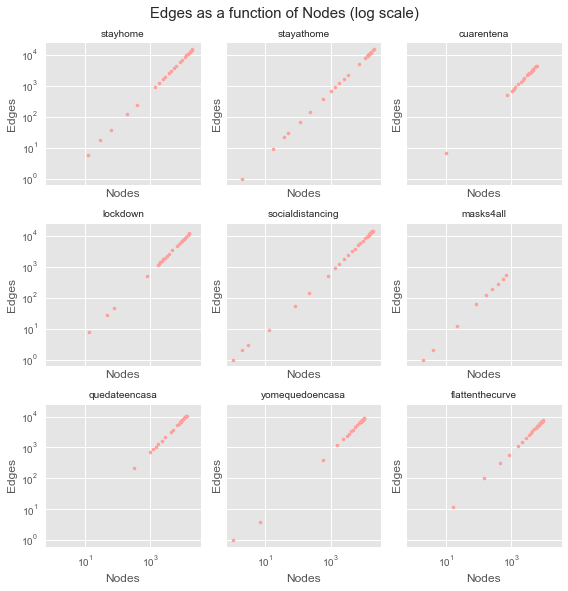

In [534]:
fig, axs = plt.subplots(3,3, figsize=(8, 8), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(len(hashtag_list)):

    axs[i].plot(info_pd_list[i]['nodes'], info_pd_list[i]['edges'], '.', c='r')
    axs[i].set_title('{}'.format(hashtag_list[i]), fontsize=10)
    axs[i].set_ylabel('Edges')
    axs[i].set_xlabel('Nodes')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')

fig.suptitle('Edges as a function of Nodes (log scale)', fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

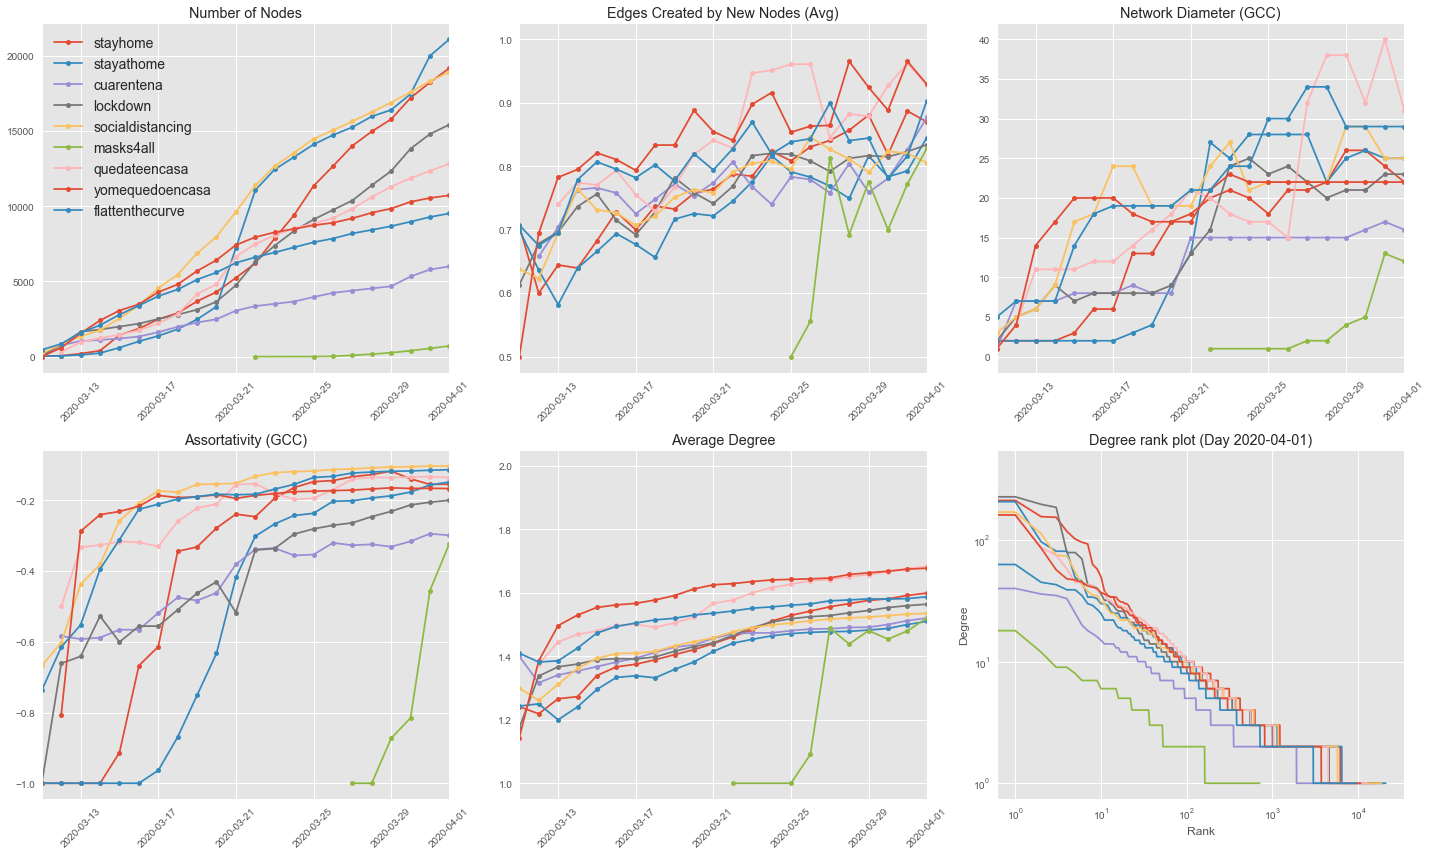

In [546]:
num_colors = len(hashtag_list)
#cm = plt.get_cmap('Accent')

fig, axs = plt.subplots(2,3, figsize=(20, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

params={'markersize':10, 'style':'.-', 'rot':45}

for i in range(len(hashtag_list)):

    params['label'] = hashtag_list[i]
    #params['c'] = cm(1.*i/num_colors)
    info_pd_list[i]['nodes'].plot(ax=axs[0], **params, title='Number of Nodes')
    info_pd_list[i]['edges_created'].plot(ax=axs[1],  **params, title='Edges Created by New Nodes (Avg)')
    info_pd_list[i]['diameter'].plot(ax=axs[2], **params, title='Network Diameter (GCC)')
    info_pd_list[i]['assortativity'].plot(ax=axs[3], **params, title='Assortativity (GCC)')
    info_pd_list[i]['avg degrees'].plot(ax=axs[4], **params, title='Average Degree')
    axs[5].loglog(sorted([n[1] for n in list(info_pd_list[i]['degrees'][-1])], reverse=True))

axs[0].legend(prop={'size': 14})
axs[5].set_title('Degree rank plot (Day {})'.format(info_pd_list[0].index[-1]))
axs[5].set_ylabel("Degree")
axs[5].set_xlabel("Rank")

for i in range(5):
    axs[i].set_xlim(date(2020, 3, 11), date(2020, 4, 1))
fig.tight_layout()